In [2]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime


In [3]:
# list of chain ids
url  = 'https://chainid.network/chains.json'
r = requests.get(url)
chainId_list = r.json()
chainId_list = {c['chainId']:c['name'] for c in chainId_list}

In [4]:
# request all market meta data
url = '''https://aave-api-v2.aave.com/data/markets-data'''
r = requests.get(url, auth=('user', 'pass'))
market_data = [pd.Series(s) for s in r.json()['reserves']]
market_data = pd.concat(market_data, axis=1).T

In [5]:
def process_market_data(row):
    if '-' not in row['id']:
        row['version'] = 'v2'
        row['reserveId'] = row['id']
        row['chainName'] = 'Etherum Mainnet'

    else:
        reserveId_components = row['id'].split('-')
        row['version'] = 'v3'
        row['reserveId'] = reserveId_components[1] + reserveId_components[2] + reserveId_components[0]
        row['chainName'] = chainId_list[int(reserveId_components[0])]
    return row

market_data = market_data.apply(process_market_data, axis=1)

In [6]:
market_data.totalBorrowsUSD = market_data.totalBorrowsUSD.astype('float')
market_data.totalLiquidityUSD = market_data.totalLiquidityUSD.astype('float')

In [7]:
market_data.sort_values('totalLiquidityUSD', ascending=False).loc[:,['version', 'symbol','totalLiquidityUSD','chainName']]

,version,symbol,totalLiquidityUSD,chainName
177,v3,wstETH,3.955542e+09,Ethereum Mainnet
176,v3,WETH,3.276614e+09,Ethereum Mainnet
178,v3,WBTC,2.438652e+09,Ethereum Mainnet
204,v3,weETH,2.273869e+09,Ethereum Mainnet
184,v3,USDT,1.685783e+09,Ethereum Mainnet
...,...,...,...,...
73,v2,AAMMUNISNXWETH,0.000000e+00,Etherum Mainnet
76,v2,AAMMUNIWBTCUSDC,0.000000e+00,Etherum Mainnet
71,v2,AAMMUNIMKRWETH,0.000000e+00,Etherum Mainnet
77,v2,AAMMUNIYFIWETH,0.000000e+00,Etherum Mainnet


In [12]:
toFetch = market_data.sort_values('totalBorrowsUSD', ascending=False).loc[:,['version', 'symbol','totalBorrowsUSD', 'chainName']].head(5)
toFetch_dfId = toFetch.index
toFetch

,version,symbol,totalBorrowsUSD,chainName
176,v3,WETH,2.920673e+09,Ethereum Mainnet
184,v3,USDT,1.380702e+09,Ethereum Mainnet
179,v3,USDC,1.348823e+09,Ethereum Mainnet
178,v3,WBTC,3.266008e+08,Ethereum Mainnet
139,v3,WETH,3.114225e+08,Arbitrum One


In [22]:
def to_datetime(date_dict):
    try:
        # Check if all required keys are present and values are valid integers
        required_keys = ['year', 'month', 'date', 'hours']
        if all(key in date_dict and isinstance(date_dict[key], int) for key in required_keys):
            return datetime(
                year=date_dict['year'],
                month=date_dict['month'],
                day=date_dict['date'],
                hour=date_dict['hours']
            )
        else:
            return None
    except Exception as e:
        return None



In [27]:
# The id of the Aave reserve you want to query. For V2 markets: assetAddress + lendingPoolAddressesProvider. For V3 markets: assetAddress + poolAddressesProvider + chainId.
# reserveId = market_data.loc[market_data.symbol == 'DAI'].id.iloc[0]

dfs = {}
for dfId  in toFetch_dfId:
    print(dfId)
    reserveId = market_data.loc[dfId, 'reserveId']
    url = '''https://aave-api-v2.aave.com/data/rates-history?reserveId=%s&from=1427317635&resolutionInHours=1'''%reserveId
    r = requests.get(url, auth=('user', 'pass'))
    df = pd.DataFrame(r.json())
    df.x = df.x.apply(to_datetime)
    dfs[dfId] = df

176
184
179
178
139


In [36]:
for dfId in toFetch_dfId:
    symbol = market_data.loc[dfId, 'symbol']
    version = market_data.loc[dfId, 'version']
    chainName = market_data.loc[dfId, 'chainName']
    fileName = f'../data/{symbol}_AAVE_{version}_{chainName}_variableBorrowRate_avg.csv'
    dfs[dfId].to_csv(fileName)

In [33]:
dfs[dfId].to_csv('a.csv')

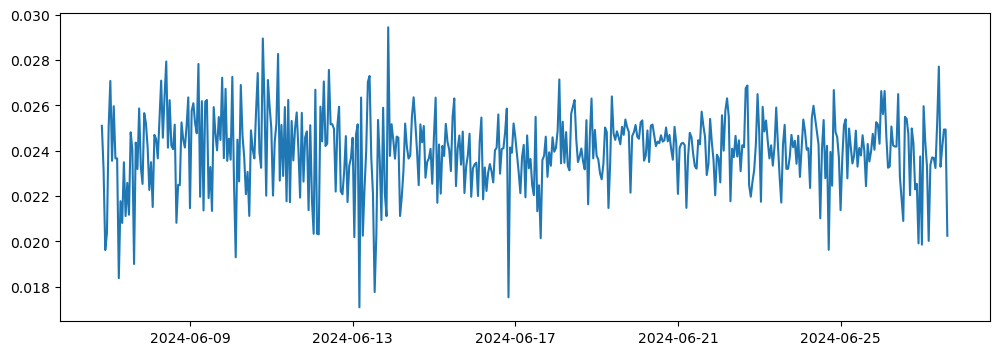

In [51]:
plt.figure(figsize=(12,4))
_df = df.copy().tail(500)
plt.plot(_df.x, _df.variableBorrowRate_avg, marker=None)

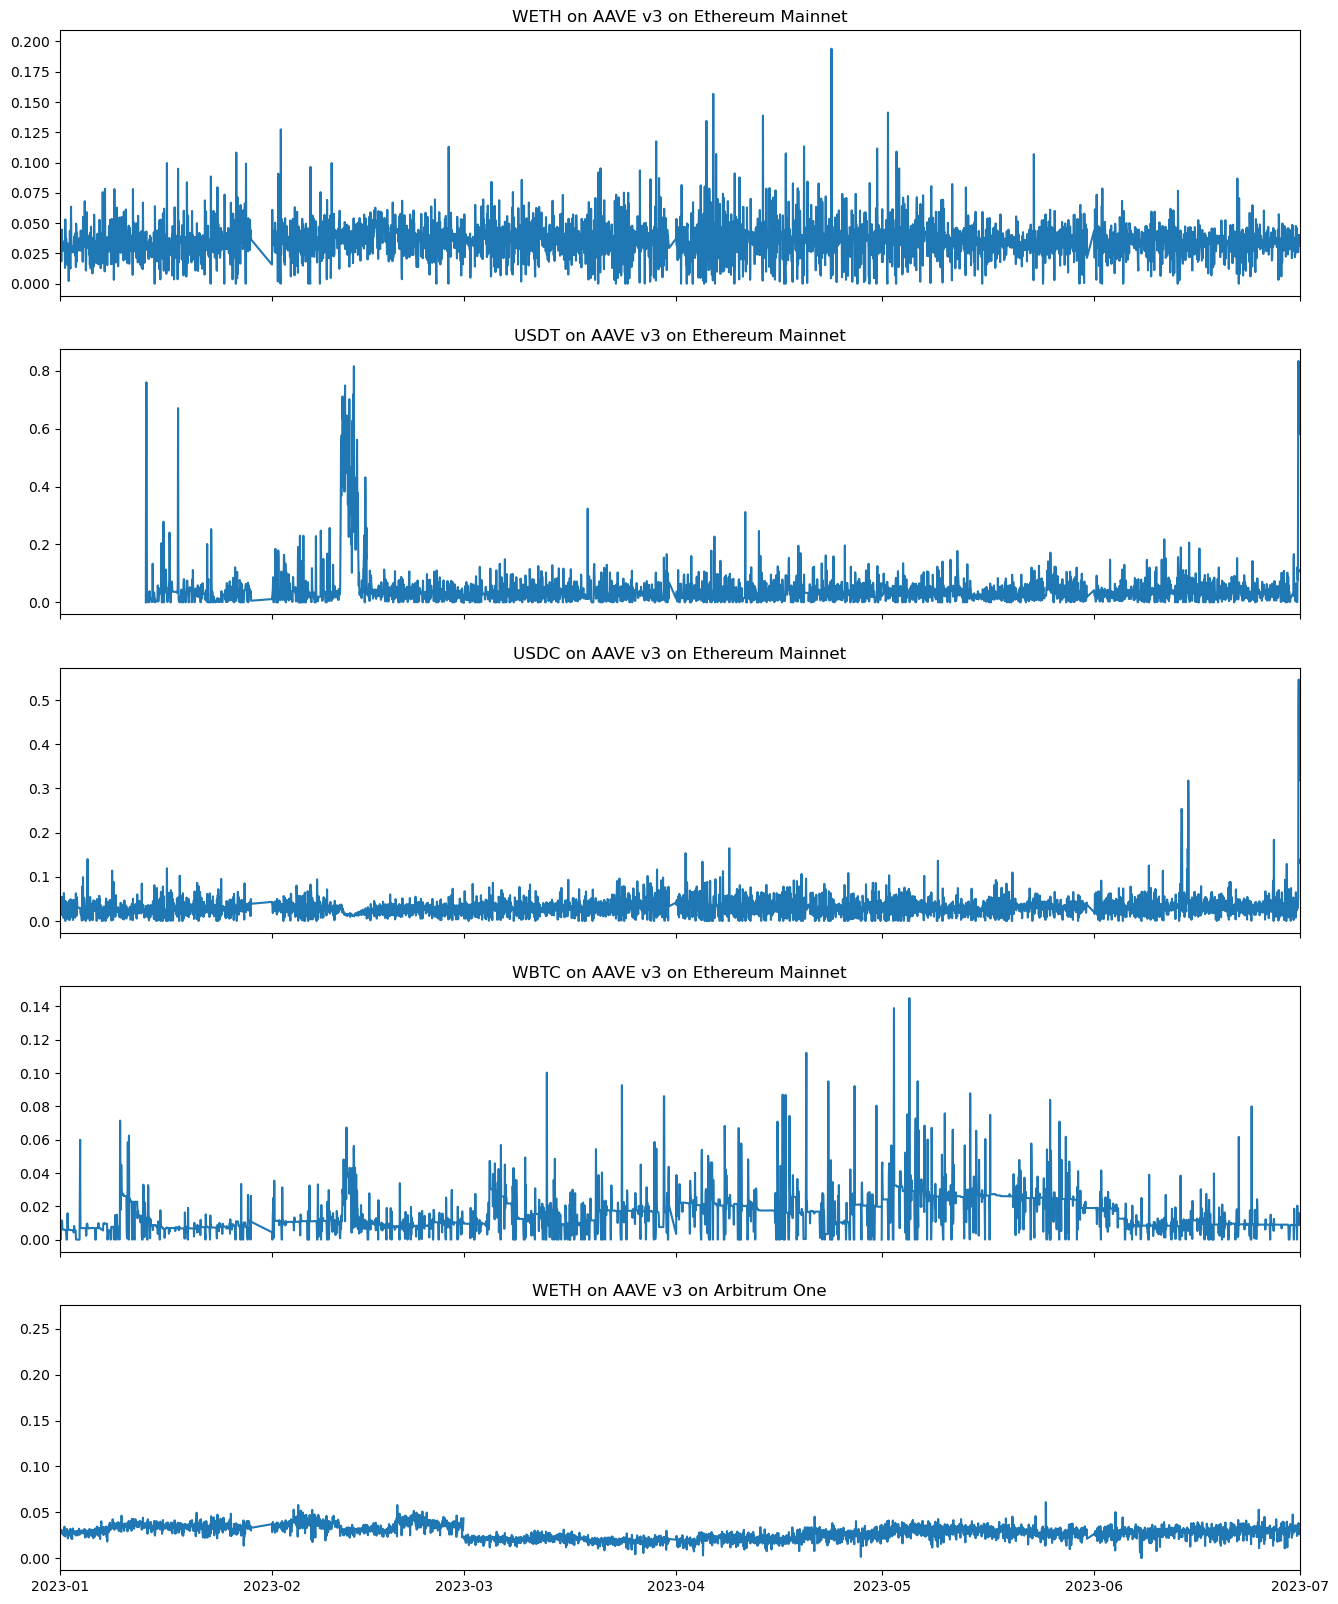

In [61]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16,20),
                         sharex=True, sharey=False)

for i, dfId in enumerate(toFetch_dfId):
    symbol = market_data.loc[dfId, 'symbol']
    version = market_data.loc[dfId, 'version']
    chainName = market_data.loc[dfId, 'chainName']
    df = dfs[dfId]
    
    axes[i].set_title(f'{symbol} on AAVE {version} on {chainName}')
    axes[i].plot(df.x, df.variableBorrowRate_avg)
    axes[i].set_xlim(pd.to_datetime(['2023-01-01', '2023-07-01']))


In [ ]:
https://www.jstor.org/stable/27919566